In [78]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import random
random.seed(11)
%matplotlib inline

## Load H2o

NOTE: to start H2o, first use Terminal to navigate to *usr/local/lib/python3.6/site-packages/h2o/backend/bin* and enter the command *java -jar h2o.jar*

In [80]:
# Load the H2O library and start up the H2O cluster locally on your machine
import h2o
from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

# Number of threads, nthreads = -1, means use all cores on your machine
# max_mem_size is the maximum memory (in GB) to allocate to H2O
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,02 secs
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.11
H2O cluster version age:,1 month and 9 days
H2O cluster name:,garrettfiddler
H2O cluster total nodes:,1
H2O cluster free memory:,2 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


## Load data

In [81]:
khous_df = pd.read_csv('khous_train.csv')

In [82]:
khous_df.shape

(1460, 81)

In [83]:
khous_df.dtypes.value_counts()

object     43
int64      35
float64     3
dtype: int64

In [84]:
khous_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [85]:
khous_null_df = khous_df.mask(np.random.random(khous_df.shape) < .5)

## Convert data to H2o

In [86]:
khous_h2 = h2o.H2OFrame(khous_df)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [87]:
khous_null_h2 = h2o.H2OFrame(khous_null_df)

Parse progress: |█████████████████████████████████████████████████████████| 100%


## Build Models

In [88]:
loss_by_type = {np.dtype('object'):"Categorical", 
                np.dtype('int64'):"Quadratic", 
                np.dtype('float64'):"Quadratic", 
                np.dtype('bool'):"Hinge"}
col_loss_types = [loss_by_type[obj_type] for obj_type in khous_df.dtypes]

In [89]:
khous_h2.head()

Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1,60,RL,65,8450,Pave,nan,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,nan,Attchd,2003,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,nan,nan,nan,0,2,2008,WD,Normal,208500
2,20,RL,80,9600,Pave,nan,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,nan,nan,nan,0,5,2007,WD,Normal,181500
3,60,RL,68,11250,Pave,nan,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,nan,nan,nan,0,9,2008,WD,Normal,223500
4,70,RL,60,9550,Pave,nan,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,nan,nan,nan,0,2,2006,WD,Abnorml,140000
5,60,RL,84,14260,Pave,nan,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,nan,nan,nan,0,12,2008,WD,Normal,250000
6,50,RL,85,14115,Pave,nan,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,Ex,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,nan,Attchd,1993,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,nan,MnPrv,Shed,700,10,2009,WD,Normal,143000
7,20,RL,75,10084,Pave,nan,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,Ex,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,nan,nan,nan,0,8,2007,WD,Normal,307000
8,60,RL,nan,10382,Pave,nan,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,Ex,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,nan,nan,Shed,350,11,2009,WD,Normal,200000
9,50,RM,51,6120,Pave,nan,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,Gd,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931,Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,nan,nan,nan,0,4,2008,WD,Abnorml,129900
10,190,RL,50,7420,Pave,nan,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,Artery,2fmCon,1.5Unf,5,6,1939,1950,Gable,CompShg,MetalSd,MetalSd,None,0,TA,TA,BrkTil,TA,TA,No,GLQ,851,Unf,0,140,991,GasA,Ex,Y,SBrkr,1077,0,0,1077,1,0,1,0,2,2,TA,5,Typ,2,TA,Attchd,1939,RFn,1,205,Gd

In [91]:
glrmodel_2 = H2OGeneralizedLowRankEstimator(k=10, 
                                       max_iterations=100, 
                                       loss_by_col=col_loss_types, 
                                       impute_original=True)

In [92]:
glrmodel_2.train(training_frame=khous_h2)
# glrmodel_2.train(y='SalePrice', training_frame=khous_h2) <-- makes no difference?

glrm Model Build progress: |██████████████████████████████████████████████| 100%


In [ ]:
# trying something else copied directly from an example, but produces an error:
# glrmodel_4.train(x=khous_h2.names, training_frame=khous_h2)

Now let's try this on the same dataset, but with half the values nulled out:

In [111]:
glrmodel_3 = H2OGeneralizedLowRankEstimator(k=10, 
                                       max_iterations=100, 
                                       loss_by_col=col_loss_types, 
                                       impute_original=True)

In [ ]:
glrmodel_3 = H2OGeneralizedLowRankEstimator(k=10)

In [112]:
glrmodel_3.train(training_frame=khous_null_h2)

H2OResponseError: ModelBuilderErrorV3  (water.exceptions.H2OModelBuilderIllegalArgumentException):
    timestamp = 1530645727323
    error_url = '/3/ModelBuilders/glrm'
    msg = 'Illegal argument(s) for GLRM model: GLRM_model_python_1530645406753_12.  Details: ERRR on field: _loss_by_col: Loss function Quadratic cannot be applied to categorical column 0\nERRR on field: _loss_by_col: Loss function Quadratic cannot be applied to categorical column 1\nERRR on field: _loss_by_col: Loss function Quadratic cannot be applied to categorical column 3\nERRR on field: _loss_by_col: Loss function Quadratic cannot be applied to categorical column 19\nERRR on field: _loss_by_col: Loss function Quadratic cannot be applied to categorical column 20\nERRR on field: _loss_by_col: Loss function Quadratic cannot be applied to categorical column 26\nERRR on field: _loss_by_col: Loss function Quadratic cannot be applied to categorical column 38\nERRR on field: _loss_by_col: Loss function Quadratic cannot be applied to categorical column 45\nERRR on field: _loss_by_col: Loss function Quadratic cannot be applied to categorical column 46\nERRR on field: _loss_by_col: Loss function Quadratic cannot be applied to categorical column 49\nERRR on field: _loss_by_col: Loss function Quadratic cannot be applied to categorical column 52\nERRR on field: _loss_by_col: Loss function Quadratic cannot be applied to categorical column 59\nERRR on field: _loss_by_col: Loss function Quadratic cannot be applied to categorical column 62\nERRR on field: _loss_by_col: Loss function Quadratic cannot be applied to categorical column 67\nERRR on field: _loss_by_col: Loss function Quadratic cannot be applied to categorical column 70\nERRR on field: _loss_by_col: Loss function Quadratic cannot be applied to categorical column 75\nERRR on field: _loss_by_col: Loss function Quadratic cannot be applied to categorical column 76\nERRR on field: _loss_by_col: Loss function Quadratic cannot be applied to categorical column 77'
    dev_msg = 'Illegal argument(s) for GLRM model: GLRM_model_python_1530645406753_12.  Details: ERRR on field: _loss_by_col: Loss function Quadratic cannot be applied to categorical column 0\nERRR on field: _loss_by_col: Loss function Quadratic cannot be applied to categorical column 1\nERRR on field: _loss_by_col: Loss function Quadratic cannot be applied to categorical column 3\nERRR on field: _loss_by_col: Loss function Quadratic cannot be applied to categorical column 19\nERRR on field: _loss_by_col: Loss function Quadratic cannot be applied to categorical column 20\nERRR on field: _loss_by_col: Loss function Quadratic cannot be applied to categorical column 26\nERRR on field: _loss_by_col: Loss function Quadratic cannot be applied to categorical column 38\nERRR on field: _loss_by_col: Loss function Quadratic cannot be applied to categorical column 45\nERRR on field: _loss_by_col: Loss function Quadratic cannot be applied to categorical column 46\nERRR on field: _loss_by_col: Loss function Quadratic cannot be applied to categorical column 49\nERRR on field: _loss_by_col: Loss function Quadratic cannot be applied to categorical column 52\nERRR on field: _loss_by_col: Loss function Quadratic cannot be applied to categorical column 59\nERRR on field: _loss_by_col: Loss function Quadratic cannot be applied to categorical column 62\nERRR on field: _loss_by_col: Loss function Quadratic cannot be applied to categorical column 67\nERRR on field: _loss_by_col: Loss function Quadratic cannot be applied to categorical column 70\nERRR on field: _loss_by_col: Loss function Quadratic cannot be applied to categorical column 75\nERRR on field: _loss_by_col: Loss function Quadratic cannot be applied to categorical column 76\nERRR on field: _loss_by_col: Loss function Quadratic cannot be applied to categorical column 77'
    http_status = 412
    values = {'messages': [{'_log_level': 5, '_field_name': '_keep_cross_validation_predictions', '_message': 'Only for cross-validation.'}, {'_log_level': 5, '_field_name': '_keep_cross_validation_fold_assignment', '_message': 'Only for cross-validation.'}, {'_log_level': 5, '_field_name': '_fold_assignment', '_message': 'Only for cross-validation.'}, {'_log_level': 5, '_field_name': '_tweedie_power', '_message': 'Only for Tweedie Distribution.'}, {'_log_level': 5, '_field_name': '_response_column', '_message': 'Ignored for unsupervised methods.'}, {'_log_level': 5, '_field_name': '_balance_classes', '_message': 'Ignored for unsupervised methods.'}, {'_log_level': 5, '_field_name': '_class_sampling_factors', '_message': 'Ignored for unsupervised methods.'}, {'_log_level': 5, '_field_name': '_max_after_balance_size', '_message': 'Ignored for unsupervised methods.'}, {'_log_level': 5, '_field_name': '_max_confusion_matrix_size', '_message': 'Ignored for unsupervised methods.'}, {'_log_level': 1, '_field_name': '_loss_by_col', '_message': 'Loss function Quadratic cannot be applied to categorical column 0'}, {'_log_level': 1, '_field_name': '_loss_by_col', '_message': 'Loss function Quadratic cannot be applied to categorical column 1'}, {'_log_level': 1, '_field_name': '_loss_by_col', '_message': 'Loss function Quadratic cannot be applied to categorical column 3'}, {'_log_level': 1, '_field_name': '_loss_by_col', '_message': 'Loss function Quadratic cannot be applied to categorical column 19'}, {'_log_level': 1, '_field_name': '_loss_by_col', '_message': 'Loss function Quadratic cannot be applied to categorical column 20'}, {'_log_level': 1, '_field_name': '_loss_by_col', '_message': 'Loss function Quadratic cannot be applied to categorical column 26'}, {'_log_level': 1, '_field_name': '_loss_by_col', '_message': 'Loss function Quadratic cannot be applied to categorical column 38'}, {'_log_level': 1, '_field_name': '_loss_by_col', '_message': 'Loss function Quadratic cannot be applied to categorical column 45'}, {'_log_level': 1, '_field_name': '_loss_by_col', '_message': 'Loss function Quadratic cannot be applied to categorical column 46'}, {'_log_level': 1, '_field_name': '_loss_by_col', '_message': 'Loss function Quadratic cannot be applied to categorical column 49'}, {'_log_level': 1, '_field_name': '_loss_by_col', '_message': 'Loss function Quadratic cannot be applied to categorical column 52'}, {'_log_level': 1, '_field_name': '_loss_by_col', '_message': 'Loss function Quadratic cannot be applied to categorical column 59'}, {'_log_level': 1, '_field_name': '_loss_by_col', '_message': 'Loss function Quadratic cannot be applied to categorical column 62'}, {'_log_level': 1, '_field_name': '_loss_by_col', '_message': 'Loss function Quadratic cannot be applied to categorical column 67'}, {'_log_level': 1, '_field_name': '_loss_by_col', '_message': 'Loss function Quadratic cannot be applied to categorical column 70'}, {'_log_level': 1, '_field_name': '_loss_by_col', '_message': 'Loss function Quadratic cannot be applied to categorical column 75'}, {'_log_level': 1, '_field_name': '_loss_by_col', '_message': 'Loss function Quadratic cannot be applied to categorical column 76'}, {'_log_level': 1, '_field_name': '_loss_by_col', '_message': 'Loss function Quadratic cannot be applied to categorical column 77'}], 'algo': 'GLRM', 'parameters': {'_train': {'name': 'Key_Frame__upload_8d429ff92b784e9d8304bece0a49471b.hex', 'type': 'Key'}, '_valid': None, '_nfolds': 0, '_keep_cross_validation_predictions': False, '_keep_cross_validation_fold_assignment': False, '_parallelize_cross_validation': True, '_auto_rebalance': True, '_seed': -1, '_fold_assignment': 'AUTO', '_categorical_encoding': 'AUTO', '_max_categorical_levels': 10, '_distribution': 'AUTO', '_tweedie_power': 1.5, '_quantile_alpha': 0.5, '_huber_alpha': 0.9, '_ignored_columns': None, '_ignore_const_cols': True, '_weights_column': None, '_offset_column': None, '_fold_column': None, '_is_cv_model': False, '_score_each_iteration': False, '_max_runtime_secs': 0.0, '_stopping_rounds': 0, '_stopping_metric': 'AUTO', '_stopping_tolerance': 0.001, '_response_column': None, '_balance_classes': False, '_max_after_balance_size': 5.0, '_class_sampling_factors': None, '_max_confusion_matrix_size': 20, '_checkpoint': None, '_pretrained_autoencoder': None, '_custom_metric_func': None, '_transform': 'NONE', '_k': 10, '_init': 'PlusPlus', '_svd_method': 'Randomized', '_user_y': None, '_user_x': None, '_expand_user_y': True, '_loss': 'Quadratic', '_multi_loss': 'Categorical', '_period': 1, '_loss_by_col': ['Quadratic', 'Quadratic', 'Categorical', 'Quadratic', 'Quadratic', 'Categorical', 'Categorical', 'Categorical', 'Categorical', 'Categorical', 'Categorical', 'Categorical', 'Categorical', 'Categorical', 'Categorical', 'Categorical', 'Categorical', 'Quadratic', 'Quadratic', 'Quadratic', 'Quadratic', 'Categorical', 'Categorical', 'Categorical', 'Categorical', 'Categorical', 'Quadratic', 'Categorical', 'Categorical', 'Categorical', 'Categorical', 'Categorical', 'Categorical', 'Categorical', 'Quadratic', 'Categorical', 'Quadratic', 'Quadratic', 'Quadratic', 'Categorical', 'Categorical', 'Categorical', 'Categorical', 'Quadratic', 'Quadratic', 'Quadratic', 'Quadratic', 'Quadratic', 'Quadratic', 'Quadratic', 'Quadratic', 'Quadratic', 'Quadratic', 'Categorical', 'Quadratic', 'Categorical', 'Quadratic', 'Categorical', 'Categorical', 'Quadratic', 'Categorical', 'Quadratic', 'Quadratic', 'Categorical', 'Categorical', 'Categorical', 'Quadratic', 'Quadratic', 'Quadratic', 'Quadratic', 'Quadratic', 'Quadratic', 'Categorical', 'Categorical', 'Categorical', 'Quadratic', 'Quadratic', 'Quadratic', 'Categorical', 'Categorical', 'Quadratic'], '_loss_by_col_idx': None, '_regularization_x': 'None', '_regularization_y': 'None', '_gamma_x': 0.0, '_gamma_y': 0.0, '_max_iterations': 100, '_max_updates': 2000, '_init_step_size': 1.0, '_min_step_size': 0.0001, '_representation_name': None, '_recover_svd': False, '_impute_original': True, '_verbose': True}, 'error_count': 36}
    exception_msg = 'Illegal argument(s) for GLRM model: GLRM_model_python_1530645406753_12.  Details: ERRR on field: _loss_by_col: Loss function Quadratic cannot be applied to categorical column 0\nERRR on field: _loss_by_col: Loss function Quadratic cannot be applied to categorical column 1\nERRR on field: _loss_by_col: Loss function Quadratic cannot be applied to categorical column 3\nERRR on field: _loss_by_col: Loss function Quadratic cannot be applied to categorical column 19\nERRR on field: _loss_by_col: Loss function Quadratic cannot be applied to categorical column 20\nERRR on field: _loss_by_col: Loss function Quadratic cannot be applied to categorical column 26\nERRR on field: _loss_by_col: Loss function Quadratic cannot be applied to categorical column 38\nERRR on field: _loss_by_col: Loss function Quadratic cannot be applied to categorical column 45\nERRR on field: _loss_by_col: Loss function Quadratic cannot be applied to categorical column 46\nERRR on field: _loss_by_col: Loss function Quadratic cannot be applied to categorical column 49\nERRR on field: _loss_by_col: Loss function Quadratic cannot be applied to categorical column 52\nERRR on field: _loss_by_col: Loss function Quadratic cannot be applied to categorical column 59\nERRR on field: _loss_by_col: Loss function Quadratic cannot be applied to categorical column 62\nERRR on field: _loss_by_col: Loss function Quadratic cannot be applied to categorical column 67\nERRR on field: _loss_by_col: Loss function Quadratic cannot be applied to categorical column 70\nERRR on field: _loss_by_col: Loss function Quadratic cannot be applied to categorical column 75\nERRR on field: _loss_by_col: Loss function Quadratic cannot be applied to categorical column 76\nERRR on field: _loss_by_col: Loss function Quadratic cannot be applied to categorical column 77'
    stacktrace =
        water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GLRM model: GLRM_model_python_1530645406753_12.  Details: ERRR on field: _loss_by_col: Loss function Quadratic cannot be applied to categorical column 0
ERRR on field: _loss_by_col: Loss function Quadratic cannot be applied to categorical column 1
ERRR on field: _loss_by_col: Loss function Quadratic cannot be applied to categorical column 3
ERRR on field: _loss_by_col: Loss function Quadratic cannot be applied to categorical column 19
ERRR on field: _loss_by_col: Loss function Quadratic cannot be applied to categorical column 20
ERRR on field: _loss_by_col: Loss function Quadratic cannot be applied to categorical column 26
ERRR on field: _loss_by_col: Loss function Quadratic cannot be applied to categorical column 38
ERRR on field: _loss_by_col: Loss function Quadratic cannot be applied to categorical column 45
ERRR on field: _loss_by_col: Loss function Quadratic cannot be applied to categorical column 46
ERRR on field: _loss_by_col: Loss function Quadratic cannot be applied to categorical column 49
ERRR on field: _loss_by_col: Loss function Quadratic cannot be applied to categorical column 52
ERRR on field: _loss_by_col: Loss function Quadratic cannot be applied to categorical column 59
ERRR on field: _loss_by_col: Loss function Quadratic cannot be applied to categorical column 62
ERRR on field: _loss_by_col: Loss function Quadratic cannot be applied to categorical column 67
ERRR on field: _loss_by_col: Loss function Quadratic cannot be applied to categorical column 70
ERRR on field: _loss_by_col: Loss function Quadratic cannot be applied to categorical column 75
ERRR on field: _loss_by_col: Loss function Quadratic cannot be applied to categorical column 76
ERRR on field: _loss_by_col: Loss function Quadratic cannot be applied to categorical column 77
        water.exceptions.H2OModelBuilderIllegalArgumentException.makeFromBuilder(H2OModelBuilderIllegalArgumentException.java:20)
        hex.ModelBuilder.trainModel(ModelBuilder.java:239)
        water.api.ModelBuilderHandler.handle(ModelBuilderHandler.java:64)
        water.api.ModelBuilderHandler.handle(ModelBuilderHandler.java:17)
        water.api.RequestServer.serve(RequestServer.java:451)
        water.api.RequestServer.doGeneric(RequestServer.java:296)
        water.api.RequestServer.doPost(RequestServer.java:222)
        javax.servlet.http.HttpServlet.service(HttpServlet.java:755)
        javax.servlet.http.HttpServlet.service(HttpServlet.java:848)
        org.eclipse.jetty.servlet.ServletHolder.handle(ServletHolder.java:684)
        org.eclipse.jetty.servlet.ServletHandler.doHandle(ServletHandler.java:503)
        org.eclipse.jetty.server.handler.ContextHandler.doHandle(ContextHandler.java:1086)
        org.eclipse.jetty.servlet.ServletHandler.doScope(ServletHandler.java:429)
        org.eclipse.jetty.server.handler.ContextHandler.doScope(ContextHandler.java:1020)
        org.eclipse.jetty.server.handler.ScopedHandler.handle(ScopedHandler.java:135)
        org.eclipse.jetty.server.handler.HandlerCollection.handle(HandlerCollection.java:154)
        org.eclipse.jetty.server.handler.HandlerWrapper.handle(HandlerWrapper.java:116)
        water.JettyHTTPD$LoginHandler.handle(JettyHTTPD.java:197)
        org.eclipse.jetty.server.handler.HandlerCollection.handle(HandlerCollection.java:154)
        org.eclipse.jetty.server.handler.HandlerWrapper.handle(HandlerWrapper.java:116)
        org.eclipse.jetty.server.Server.handle(Server.java:370)
        org.eclipse.jetty.server.AbstractHttpConnection.handleRequest(AbstractHttpConnection.java:494)
        org.eclipse.jetty.server.BlockingHttpConnection.handleRequest(BlockingHttpConnection.java:53)
        org.eclipse.jetty.server.AbstractHttpConnection.content(AbstractHttpConnection.java:982)
        org.eclipse.jetty.server.AbstractHttpConnection$RequestHandler.content(AbstractHttpConnection.java:1043)
        org.eclipse.jetty.http.HttpParser.parseNext(HttpParser.java:865)
        org.eclipse.jetty.http.HttpParser.parseAvailable(HttpParser.java:240)
        org.eclipse.jetty.server.BlockingHttpConnection.handle(BlockingHttpConnection.java:72)
        org.eclipse.jetty.server.bio.SocketConnector$ConnectorEndPoint.run(SocketConnector.java:264)
        org.eclipse.jetty.util.thread.QueuedThreadPool.runJob(QueuedThreadPool.java:608)
        org.eclipse.jetty.util.thread.QueuedThreadPool$3.run(QueuedThreadPool.java:543)
        java.base/java.lang.Thread.run(Thread.java:844)
    parameters = {'__meta': {'schema_version': 3, 'schema_name': 'GLRMParametersV3', 'schema_type': 'GLRMParameters'}, 'model_id': None, 'training_frame': {'__meta': {'schema_version': 3, 'schema_name': 'FrameKeyV3', 'schema_type': 'Key<Frame>'}, 'name': 'Key_Frame__upload_8d429ff92b784e9d8304bece0a49471b.hex', 'type': 'Key<Frame>', 'URL': '/3/Frames/Key_Frame__upload_8d429ff92b784e9d8304bece0a49471b.hex'}, 'validation_frame': None, 'nfolds': 0, 'keep_cross_validation_predictions': False, 'keep_cross_validation_fold_assignment': False, 'parallelize_cross_validation': True, 'distribution': 'AUTO', 'tweedie_power': 1.5, 'quantile_alpha': 0.5, 'huber_alpha': 0.9, 'response_column': None, 'weights_column': None, 'offset_column': None, 'fold_column': None, 'fold_assignment': 'AUTO', 'categorical_encoding': 'AUTO', 'max_categorical_levels': 10, 'ignored_columns': None, 'ignore_const_cols': True, 'score_each_iteration': False, 'checkpoint': None, 'stopping_rounds': 0, 'max_runtime_secs': 0.0, 'stopping_metric': 'AUTO', 'stopping_tolerance': 0.001, 'custom_metric_func': None, 'transform': 'NONE', 'k': 10, 'loss': 'Quadratic', 'multi_loss': 'Categorical', 'loss_by_col': ['Quadratic', 'Quadratic', 'Categorical', 'Quadratic', 'Quadratic', 'Categorical', 'Categorical', 'Categorical', 'Categorical', 'Categorical', 'Categorical', 'Categorical', 'Categorical', 'Categorical', 'Categorical', 'Categorical', 'Categorical', 'Quadratic', 'Quadratic', 'Quadratic', 'Quadratic', 'Categorical', 'Categorical', 'Categorical', 'Categorical', 'Categorical', 'Quadratic', 'Categorical', 'Categorical', 'Categorical', 'Categorical', 'Categorical', 'Categorical', 'Categorical', 'Quadratic', 'Categorical', 'Quadratic', 'Quadratic', 'Quadratic', 'Categorical', 'Categorical', 'Categorical', 'Categorical', 'Quadratic', 'Quadratic', 'Quadratic', 'Quadratic', 'Quadratic', 'Quadratic', 'Quadratic', 'Quadratic', 'Quadratic', 'Quadratic', 'Categorical', 'Quadratic', 'Categorical', 'Quadratic', 'Categorical', 'Categorical', 'Quadratic', 'Categorical', 'Quadratic', 'Quadratic', 'Categorical', 'Categorical', 'Categorical', 'Quadratic', 'Quadratic', 'Quadratic', 'Quadratic', 'Quadratic', 'Quadratic', 'Categorical', 'Categorical', 'Categorical', 'Quadratic', 'Quadratic', 'Quadratic', 'Categorical', 'Categorical', 'Quadratic'], 'loss_by_col_idx': None, 'period': 1, 'regularization_x': 'None', 'regularization_y': 'None', 'gamma_x': 0.0, 'gamma_y': 0.0, 'max_iterations': 100, 'max_updates': 2000, 'init_step_size': 1.0, 'min_step_size': 0.0001, 'seed': -1, 'init': 'PlusPlus', 'svd_method': 'Randomized', 'user_y': None, 'user_x': None, 'loading_name': None, 'expand_user_y': True, 'impute_original': True, 'recover_svd': False}
    messages = [{'__meta': {'schema_version': 3, 'schema_name': 'ValidationMessageV3', 'schema_type': 'ValidationMessage'}, 'message_type': 'TRACE', 'field_name': 'keep_cross_validation_predictions', 'message': 'Only for cross-validation.'}, {'__meta': {'schema_version': 3, 'schema_name': 'ValidationMessageV3', 'schema_type': 'ValidationMessage'}, 'message_type': 'TRACE', 'field_name': 'keep_cross_validation_fold_assignment', 'message': 'Only for cross-validation.'}, {'__meta': {'schema_version': 3, 'schema_name': 'ValidationMessageV3', 'schema_type': 'ValidationMessage'}, 'message_type': 'TRACE', 'field_name': 'fold_assignment', 'message': 'Only for cross-validation.'}, {'__meta': {'schema_version': 3, 'schema_name': 'ValidationMessageV3', 'schema_type': 'ValidationMessage'}, 'message_type': 'TRACE', 'field_name': 'tweedie_power', 'message': 'Only for Tweedie Distribution.'}, {'__meta': {'schema_version': 3, 'schema_name': 'ValidationMessageV3', 'schema_type': 'ValidationMessage'}, 'message_type': 'TRACE', 'field_name': 'response_column', 'message': 'Ignored for unsupervised methods.'}, {'__meta': {'schema_version': 3, 'schema_name': 'ValidationMessageV3', 'schema_type': 'ValidationMessage'}, 'message_type': 'TRACE', 'field_name': 'balance_classes', 'message': 'Ignored for unsupervised methods.'}, {'__meta': {'schema_version': 3, 'schema_name': 'ValidationMessageV3', 'schema_type': 'ValidationMessage'}, 'message_type': 'TRACE', 'field_name': 'class_sampling_factors', 'message': 'Ignored for unsupervised methods.'}, {'__meta': {'schema_version': 3, 'schema_name': 'ValidationMessageV3', 'schema_type': 'ValidationMessage'}, 'message_type': 'TRACE', 'field_name': 'max_after_balance_size', 'message': 'Ignored for unsupervised methods.'}, {'__meta': {'schema_version': 3, 'schema_name': 'ValidationMessageV3', 'schema_type': 'ValidationMessage'}, 'message_type': 'TRACE', 'field_name': 'max_confusion_matrix_size', 'message': 'Ignored for unsupervised methods.'}, {'__meta': {'schema_version': 3, 'schema_name': 'ValidationMessageV3', 'schema_type': 'ValidationMessage'}, 'message_type': 'ERRR', 'field_name': 'loss_by_col', 'message': 'Loss function Quadratic cannot be applied to categorical column 0'}, {'__meta': {'schema_version': 3, 'schema_name': 'ValidationMessageV3', 'schema_type': 'ValidationMessage'}, 'message_type': 'ERRR', 'field_name': 'loss_by_col', 'message': 'Loss function Quadratic cannot be applied to categorical column 1'}, {'__meta': {'schema_version': 3, 'schema_name': 'ValidationMessageV3', 'schema_type': 'ValidationMessage'}, 'message_type': 'ERRR', 'field_name': 'loss_by_col', 'message': 'Loss function Quadratic cannot be applied to categorical column 3'}, {'__meta': {'schema_version': 3, 'schema_name': 'ValidationMessageV3', 'schema_type': 'ValidationMessage'}, 'message_type': 'ERRR', 'field_name': 'loss_by_col', 'message': 'Loss function Quadratic cannot be applied to categorical column 19'}, {'__meta': {'schema_version': 3, 'schema_name': 'ValidationMessageV3', 'schema_type': 'ValidationMessage'}, 'message_type': 'ERRR', 'field_name': 'loss_by_col', 'message': 'Loss function Quadratic cannot be applied to categorical column 20'}, {'__meta': {'schema_version': 3, 'schema_name': 'ValidationMessageV3', 'schema_type': 'ValidationMessage'}, 'message_type': 'ERRR', 'field_name': 'loss_by_col', 'message': 'Loss function Quadratic cannot be applied to categorical column 26'}, {'__meta': {'schema_version': 3, 'schema_name': 'ValidationMessageV3', 'schema_type': 'ValidationMessage'}, 'message_type': 'ERRR', 'field_name': 'loss_by_col', 'message': 'Loss function Quadratic cannot be applied to categorical column 38'}, {'__meta': {'schema_version': 3, 'schema_name': 'ValidationMessageV3', 'schema_type': 'ValidationMessage'}, 'message_type': 'ERRR', 'field_name': 'loss_by_col', 'message': 'Loss function Quadratic cannot be applied to categorical column 45'}, {'__meta': {'schema_version': 3, 'schema_name': 'ValidationMessageV3', 'schema_type': 'ValidationMessage'}, 'message_type': 'ERRR', 'field_name': 'loss_by_col', 'message': 'Loss function Quadratic cannot be applied to categorical column 46'}, {'__meta': {'schema_version': 3, 'schema_name': 'ValidationMessageV3', 'schema_type': 'ValidationMessage'}, 'message_type': 'ERRR', 'field_name': 'loss_by_col', 'message': 'Loss function Quadratic cannot be applied to categorical column 49'}, {'__meta': {'schema_version': 3, 'schema_name': 'ValidationMessageV3', 'schema_type': 'ValidationMessage'}, 'message_type': 'ERRR', 'field_name': 'loss_by_col', 'message': 'Loss function Quadratic cannot be applied to categorical column 52'}, {'__meta': {'schema_version': 3, 'schema_name': 'ValidationMessageV3', 'schema_type': 'ValidationMessage'}, 'message_type': 'ERRR', 'field_name': 'loss_by_col', 'message': 'Loss function Quadratic cannot be applied to categorical column 59'}, {'__meta': {'schema_version': 3, 'schema_name': 'ValidationMessageV3', 'schema_type': 'ValidationMessage'}, 'message_type': 'ERRR', 'field_name': 'loss_by_col', 'message': 'Loss function Quadratic cannot be applied to categorical column 62'}, {'__meta': {'schema_version': 3, 'schema_name': 'ValidationMessageV3', 'schema_type': 'ValidationMessage'}, 'message_type': 'ERRR', 'field_name': 'loss_by_col', 'message': 'Loss function Quadratic cannot be applied to categorical column 67'}, {'__meta': {'schema_version': 3, 'schema_name': 'ValidationMessageV3', 'schema_type': 'ValidationMessage'}, 'message_type': 'ERRR', 'field_name': 'loss_by_col', 'message': 'Loss function Quadratic cannot be applied to categorical column 70'}, {'__meta': {'schema_version': 3, 'schema_name': 'ValidationMessageV3', 'schema_type': 'ValidationMessage'}, 'message_type': 'ERRR', 'field_name': 'loss_by_col', 'message': 'Loss function Quadratic cannot be applied to categorical column 75'}, {'__meta': {'schema_version': 3, 'schema_name': 'ValidationMessageV3', 'schema_type': 'ValidationMessage'}, 'message_type': 'ERRR', 'field_name': 'loss_by_col', 'message': 'Loss function Quadratic cannot be applied to categorical column 76'}, {'__meta': {'schema_version': 3, 'schema_name': 'ValidationMessageV3', 'schema_type': 'ValidationMessage'}, 'message_type': 'ERRR', 'field_name': 'loss_by_col', 'message': 'Loss function Quadratic cannot be applied to categorical column 77'}]
    error_count = 36


Strange: this throws a wrong-loss-for-column-type error when used on the same exact dataset, but with nulls.  It builds successfully if I don't pass in the specific loss functions for columns dictionary.

## Test and use model

In [97]:
glrmodel_2.proj_archetypes(khous_h2)

Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
685.98,41.2626,RL,86.6412,13495.3,Pave,nan,IR1,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,8.13131,5.22727,1998.48,2001.81,Gable,CompShg,VinylSd,VinylSd,BrkFace,336.958,Gd,TA,PConc,Gd,TA,No,GLQ,783,Unf,26.202,823.808,1633.01,GasA,Ex,Y,SBrkr,1663.53,488.232,1.77636e-15,2151.76,0.651515,0.010101,2.06061,0.510101,3.05556,1,Gd,8.09091,Typ,1.12626,Gd,Attchd,2000.02,Fin,2.69192,743,TA,TA,Y,180.46,88.6616,10.1616,2.38384,16.5556,2.80303,nan,nan,nan,10.101,6.66667,2007.78,WD,Normal,321946
401.75,70,RL,90.0375,163514,Pave,nan,IR2,Low,AllPub,CulDSac,Sev,ClearCr,Norm,Norm,1Fam,1.5Fin,6.25,5.75,1964.75,1984.5,Gable,CompShg,Plywood,Plywood,None,205.75,TA,TA,CBlock,Gd,TA,Gd,ALQ,1100.25,Unf,241.75,338.5,1680.5,GasA,TA,Y,SBrkr,1730.75,216.75,0,1947.5,1.25,0.25,2,0,3,1,Gd,6.75,Typ,2,Gd,Attchd,1964.75,Fin,2,542.5,TA,TA,Y,262.5,36.5,0,0,-1.77636e-15,0,nan,nan,Shed,300,6.5,2007.75,WD,Normal,295738
808.298,63.0124,RL,69.0475,11014.5,Pave,nan,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,6.06832,6.27329,1946.04,1975.6,Gable,CompShg,Wd Sdng,Wd Sdng,None,83.3851,TA,TA,CBlock,TA,TA,No,Unf,251.28,Unf,48.236,590.46,889.975,GasA,TA,Y,SBrkr,1127.55,721.304,1.2236,1850.08,0.186335,-6.93889e-17,1.65839,0.639752,3.52795,1,TA,7.57764,Typ,0.993789,Gd,Attchd,1957.54,Unf,1.65217,421.416,TA,TA,Y,81.8634,50.9006,40.9503,3.56522,39.8634,7.80745,nan,nan,nan,45.3416,6.85093,2007.66,WD,Normal,177573
732.146,41.3605,RL,73.2582,11194,Pave,nan,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5.40136,5.84354,1967.43,1978.04,Gable,CompShg,HdBoard,HdBoard,None,75.5102,TA,TA,CBlock,TA,TA,No,ALQ,660.541,Unf,117.224,319.095,1096.86,GasA,TA,Y,SBrkr,1178.79,24.2993,0,1203.09,0.789116,6.93889e-18,1.17347,0.238095,2.65646,1.0102,TA,5.66327,Typ,0.595238,nan,Attchd,1970.63,Unf,1.65306,466.439,TA,TA,Y,102.041,30.483,12.398,4.81973,23.9184,4.16327,nan,nan,nan,85.5442,5.96939,2008.05,WD,Normal,152158
721.656,50.9825,RL,59.4228,7494.69,Pave,nan,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,1Story,4.82456,5.72281,1942.36,1968.73,Gable,CompShg,MetalSd,MetalSd,None,23.7333,TA,TA,CBlock,TA,TA,No,Unf,208.119,Unf,20.0772,509.509,737.705,GasA,TA,Y,SBrkr,865.467,190.902,2.60351,1058.97,0.175439,-2.08167e-17,1.05263,0.136842,2.4807,1,TA,5.28772,Typ,0.203509,nan,Detchd,1959.94,Unf,1.02105,278.288,TA,TA,Y,30.7754,18.2105,48.9965,0.631579,4.75088,-8.88178e-15,nan,nan,nan,34.6807,6.14737,2007.79,WD,Normal,106640
709.16,52.2667,RL,68.104,10570.1,Pave,nan,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5.76,6.17333,1966.87,1983.2,Gable,CompShg,VinylSd,VinylSd,None,102.427,TA,TA,CBlock,TA,TA,No,ALQ,555.773,Unf,98.2533,359.213,1013.24,GasA,Ex,Y,SBrkr,1130.57,236.28,-8.88178e-16,1366.85,0.0933333,1.02667,1.37333,0.32,2.88,0.986667,TA,6.08,Typ,0.653333,nan,Attchd,1971.29,Unf,1.65333,434.427,TA,TA,Y,120.173,39.3467,14.8,8.6,23.8667,4.44089e-16,nan,nan,nan,25.0667,6.70667,2007.61,WD,Normal,165198
593.588,68.2353,RL,79.1206,10902.7,Pave,nan,Reg,Lvl,AllPub,Inside,Gtl,SWISU,Norm,Norm,1Fam,1.5Fin,5.82353,5.64706,1920.76,1973.71,Gable,CompShg,Wd Sdng,Wd Sdng,None,0,TA,TA,BrkTil,TA,TA,No,Unf,197.059,Unf,79.1176,676.647,952.824,GasA,Ex,Y,SBrkr,

               timestamp    duration  iterations  step_size     objective
0    2018-07-03 12:17:37   2.458 sec         0.0   0.666667  1.002953e+13
1    2018-07-03 12:17:37   2.831 sec         1.0   0.444444  1.002953e+13
2    2018-07-03 12:17:37   2.974 sec         2.0   0.222222  1.002953e+13
3    2018-07-03 12:17:38   3.119 sec         3.0   0.074074  1.002953e+13
4    2018-07-03 12:17:38   3.243 sec         4.0   0.018519  1.002953e+13
5    2018-07-03 12:17:38   3.367 sec         5.0   0.003704  1.002953e+13
6    2018-07-03 12:17:38   3.501 sec         6.0   0.000617  1.002953e+13
7    2018-07-03 12:17:38   3.626 sec         7.0   0.000088  1.002953e+13


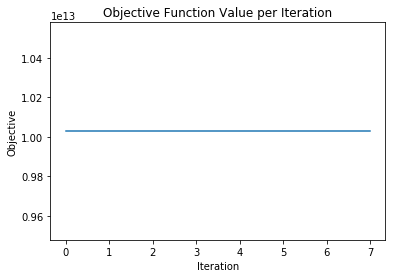

In [98]:
# Plot objective function value each iteration
model_score = glrmodel_2.score_history()
plt.xlabel("Iteration")
plt.ylabel("Objective")
plt.title("Objective Function Value per Iteration")
print(model_score)
plt.plot(model_score["iterations"], model_score["objective"])
plt.show()

In [99]:
glrmodel_2.cross_validation_holdout_predictions

Model Details
H2OGeneralizedLowRankEstimator :  Generalized Low Rank Modeling
Model Key:  GLRM_model_python_1530645406753_1


ModelMetricsGLRM: glrm
** Reported on train data. **

MSE: NaN
RMSE: NaN
Sum of Squared Error (Numeric): 10029528439220.22
Misclassification Error (Categorical): 16314.0
Scoring History: 


,timestamp,duration,iterations,step_size,objective
,2018-07-03 12:17:37,2.458 sec,0.0,0.6666667,10029528807927.8671875
,2018-07-03 12:17:37,2.831 sec,1.0,0.4444444,10029528807927.8671875
,2018-07-03 12:17:37,2.974 sec,2.0,0.2222222,10029528807927.8671875
,2018-07-03 12:17:38,3.119 sec,3.0,0.0740741,10029528807927.8671875
,2018-07-03 12:17:38,3.243 sec,4.0,0.0185185,10029528807927.8671875
,2018-07-03 12:17:38,3.367 sec,5.0,0.0037037,10029528807927.8671875
,2018-07-03 12:17:38,3.501 sec,6.0,0.0006173,10029528807927.8671875
,2018-07-03 12:17:38,3.626 sec,7.0,0.0000882,10029528807927.8671875


<bound method ModelBase.cross_validation_holdout_predictions of >

In [100]:
glrmodel_2.weights

Model Details
H2OGeneralizedLowRankEstimator :  Generalized Low Rank Modeling
Model Key:  GLRM_model_python_1530645406753_1


ModelMetricsGLRM: glrm
** Reported on train data. **

MSE: NaN
RMSE: NaN
Sum of Squared Error (Numeric): 10029528439220.22
Misclassification Error (Categorical): 16314.0
Scoring History: 


,timestamp,duration,iterations,step_size,objective
,2018-07-03 12:17:37,2.458 sec,0.0,0.6666667,10029528807927.8671875
,2018-07-03 12:17:37,2.831 sec,1.0,0.4444444,10029528807927.8671875
,2018-07-03 12:17:37,2.974 sec,2.0,0.2222222,10029528807927.8671875
,2018-07-03 12:17:38,3.119 sec,3.0,0.0740741,10029528807927.8671875
,2018-07-03 12:17:38,3.243 sec,4.0,0.0185185,10029528807927.8671875
,2018-07-03 12:17:38,3.367 sec,5.0,0.0037037,10029528807927.8671875
,2018-07-03 12:17:38,3.501 sec,6.0,0.0006173,10029528807927.8671875
,2018-07-03 12:17:38,3.626 sec,7.0,0.0000882,10029528807927.8671875


<bound method ModelBase.weights of >

do I need to set categorical variables as asfactor()  ?


Jason thought he remembered 'categorical' getting parsed differently from 'enum', hence the little loop below which changes all the dtypes to 'categorical'.  So I might want want to try a similar thing with just my enums and see what changes.

In [ ]:
types = {} 
for k in region_a_df.types: 
    types[k] = 'categorical' 
    types['C1'] = 'string' 
region_a_df = h2o.H2OFrame(np.array(region_answers)[:,1:], column_types=types) region_a_df.describe()

glrm.train(y=y, training_frame=region_a_df)

In [ ]:
khous_h2.types